# Painting with GANs

### Table of Contents

1. [Data Description](#Data-Description)
2. [Downloading data on local machine with Kaggle](#Downloading-data-on-your-local-machine-with-Kaggle)
3. [Extracting data into your local machine](#Extracting-data-into-your-local-machine)
4. [Data Preprocessing and Loading](#Data-Preprocessing-and-Loading)
5. [Defining dataset class and model inputs](#Defining-dataset-class-and-model-inputs)
6. [Building the Generator network](#Building-the-Generator-network)
7. [Building the Discriminator network](#Building-the-Discriminator-network)
8. [Calculating Model Loss](#Calculating-Model-Loss)
9. [Optimizing Model Parameters](#Optimizing-Model-Parameters)
10. [Building the GAN model](#Building-the-GAN-model)
11. [Hyperparameters](#Hyperparameters)
12. [Training the DCGAN](#Training-the-DCGAN)
13. [Evaluating the DCGAN](#Evaluating-the-DCGAN)

**Note**: In this iPython notebook, the terms paintings, art images, artworks, and images of paintings are used somewhat interchangably.

### Data Description

The dataset we will be using for this project are the art images curated by Kaggle user, [Danil](https://www.kaggle.com/thedownhill). While the dataset contains 5 different kinds of data, we will only be using images from the paintings dataset. In addition, the data has already been separated into training and test dataset. For the purpose of our study, however, we will concatenate both sources of data (as GANs are unsupervised machine learning algorithms), and feed them in both networks.

More information regarding the dataset used can be found [here](https://www.kaggle.com/thedownhill/art-images-drawings-painting-sculpture-engraving).

### Downloading data on your local machine with Kaggle

You can refer to the following to learn how to download the data using Kaggle on the command line interface (Mac users can use Terminal):

1. Download the [Kaggle API](https://github.com/Kaggle/kaggle-api): `pip install kaggle`.
2. Generate your API credentials by signing up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile - https://www.kaggle.com/(your-username)/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location **~/.kaggle/kaggle.json** (on Windows in the location **C:\Users\<Windows-username>\.kaggle\kaggle.json**).
3. Download the dataset using the following code on the CLI: `kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving` - this downloads a 581 Megabyte file that contains both the training and musemart data.
4. The data will appear in the **~./kaggle/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving folder**.

### Extracting data into your local machine

As we are dealing with zipped files, we unzip these files using the zipfile library and save them to a new directory.

In [1]:
!mkdir data

mkdir: data: File exists


In [2]:
import os
import zipfile

def extract_data():
    current_path = os.getcwd()
    datafolder = os.path.join(current_path, 'data')
    
    if len(os.listdir(datafolder)): 
        print('Files are already extracted!')
        return 
    
    for file in os.listdir(current_path):
        if file.endswith('.zip'):
            ref = zipfile.ZipFile(file, 'r')
            ref.extractall(datafolder)
            ref.close()
    print('Files are extracted!')
    
extract_data()

Files are already extracted!


After extracting the files, it returns a folder named `dataset_updated` folder with 2 folders - `training_set` and `validation_set`. As we are interested in only generating images of paintings, we will only look at the `painting` folder in each folder.

In [3]:
def painting_dir():
    current_path = os.getcwd()
    data_directory = 'data/dataset_updated'
    
    train_paintings_dir = os.path.join(current_path, data_directory, 'training_set/painting')
    val_paintings_dir = os.path.join(current_path, data_directory, 'validation_set/painting')
    
    return train_paintings_dir, val_paintings_dir

train_painting_dir, val_painting_dir = painting_dir()

In [4]:
def painting_path(painting_dir): 
    return [os.path.join(painting_dir, image_path) for image_path in os.listdir(painting_dir)]

train_painting_path = painting_path(train_painting_dir)
val_painting_path = painting_path(val_painting_dir)

### Data Preprocessing and Loading

Next, we write a function to reshape the dimensions of all images in our training and test dataset to 64 by 64 pixels. Then, we proceed to scale the images, so that they have a range between -1 and 1, as the hyperbolic tangent activation function used by the generator produces an ouput between -1 and 1. 

The following code used to reshape images were adapted from [jhayes](https://github.com/jhayes14/GAN). First, we import key libraries used to manipulate image data:

1. numpy - for data manipulation
2. tensorflow - to build the GAN
3. cv2 - to read and reshape the image data
4. pickle - to serialize and de-serialize Python object structures
5. matplotlib - to plot the images

In [5]:
import numpy as np
import tensorflow as tf
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
def load_image(img_path):
    # Read and reshape image into 64 by 64 pixels
    img = cv2.imread(img_path)
    img = np.float32(cv2.resize(img, (64, 64)))
    
    # Conduct feature scaling (range will be from (-1, 1))
    img = (2*img/255) - 1
    return img

Let's read the training and validation images into Python. We define a function that takes a `data_path` as its argument, and read the files in the path and store them in a numpy array.

In [7]:
def load_train_images(data_path):
    images = []
    for image_path in data_path:
        # As some data are corrupted, we use a try/except to catch such files and skip them
        try: 
            images.append(load_image(image_path))
        except: continue
    return np.array(images)

train_data = load_train_images(train_painting_path)
test_data = load_train_images(val_painting_path)

Let's take a look at some of the actual images, and how they look after reshaping and feature preprocessing!

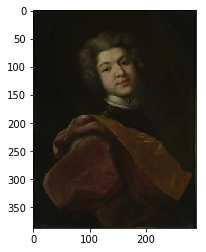

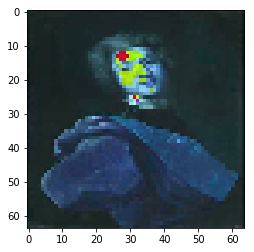

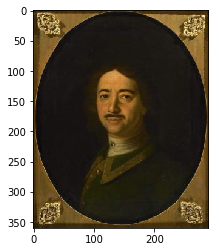

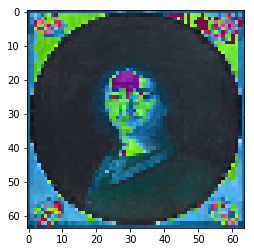

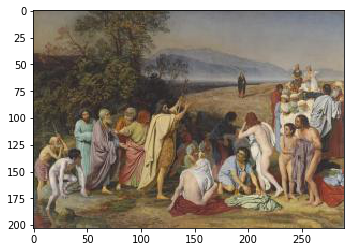

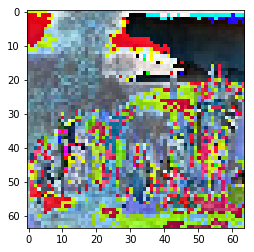

In [8]:
def show_image(image_path, reshaped_image):
    image = mpimg.imread(image_path)
    plt.imshow(image)
    plt.show()
    
    plt.imshow(reshaped_image)
    plt.show()
    
show_image(train_painting_path[0], train_data[0])
show_image(train_painting_path[2], train_data[1])
show_image(train_painting_path[3], train_data[2])

After feature pre-processing and reshaping, the new images have dimensions 64 by 64 pixels and have values between -1 and 1 for each pixel.

Lastly, we concatenate both sources of data to form a new dataset, since our goal here is to generate images that are similar to authentic artworks, and not to predict whether a certain image is an image of a painting.

In [9]:
train_data = np.concatenate([train_data, test_data])

### Defining dataset class and model inputs

Let's define a class that takes the training and test data as its inputs, and has a batches `method` that [yields](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) batches. Finally, we will create some placeholders to hold both the real and generated inputs. 

In [10]:
# Generate function that returns a placeholder containing the dimensions similar to that of the 
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [11]:
class Dataset:
    def __init__(self, train):
        self.trainlen = train.shape[3]
        self.train_x = train
        self.train_x = np.rollaxis(self.train_x, 3)
        
    def batches(self, batch_size):
        n_batches = self.trainlen//batch_size
        for ii in range(0, self.trainlen, batch_size):
            x = self.train_x[ii:ii+batch_size]
            yield x

### Building the Generator network

Next, we begin building our generator neural network. Regarding the architecture of our generator network, we start off with a fully connected dense hidden layer, and use batch normalization and convolutional transpose to connect the random noise sampled from a random uniform distribution to a fully connected layer with 8x8x128 nodes, and end up with a 64x64x3 image by the end of the transformation.

In the DCGAN paper, it is suggested that we employ a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values (affected by the parameter, alpha).

Lastly, our choice of the activation function with be that of the hyperbolic tangent function, which outputs a value from -1 to 1.

**Model Architecture**: For the generator network, I opted for a 4-layer neural network, starting with 1 fully connected layer with Leaky ReLU activation, followed by 3 convolutional transpose layers, ending with a hyperbolic tangent activation function.

In [12]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        out_dim : Shape of the generator output
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 8*8*128)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 8, 8, 128))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # current dimension: 8x8x128

        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # current dimension: 16x16x64
        
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # current dimension: 32x32x32

        # Output layer - 64x64x3 image
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out

### Building the Discriminator network

The archiecture of our discriminator is similar to that of a convolutional network, except it does not include pooling layers. Also, we use a leaky ReLU activation in place of the standard ReLU activation function. 

We note that the inputs to the discriminator network is a 64x64x3 image - we can pass the image through a few convolutional layers before connecting it to a fully connected layer at the end. We use a sigmoid activation for the discriminator network as the aim of the network is to differentiate between authentic artworks and images generated by the generator network (a binary choice).

**Model Architecture**: For the discriminator network, I opted for a 4 layer neural network: 3 Convolutional layers with Leaky ReLU activations, and a fully connected layer with sigmoid activation.

In [13]:
def discriminator(x, reuse=False, alpha=0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 64x64x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # current dimension: 32x32x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #  current dimension: 16x16x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # current dimension: 8x8x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 8*8*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

### Calculating Model Loss

Next, we need to calculate the losses for the discriminator and generator. Recall that the aim of the discriminator is to discriminate between real and generated images, while the aim of the generator is to generate images that can 'fool' the discriminator into thinking that these generated images are in fact, real images.

Thus, the discriminator makes an error when it: 
1. predicts that authentic artworks are fake; or
2. predicts that generated images are real.

On the other hand, the generator makes an error when it:
1. creates images that the discriminator network thinks are fake.

Of the many tricks and techniques listed in the [paper on improving the training of GANs](https://arxiv.org/abs/1606.03498), we employ label smoothing as it was shown to reduce the vulnerability of neural networks to adversarial examples. We use a smoothed value of 0.9 in our case, a popular choice.

In [14]:
def model_loss(real_input, z, output_dim, alpha=0.2):
    # build our generator and discriminator model
    g_model = generator(z, output_dim, reuse=False, alpha=alpha)
    d_model_real, d_real_logits = discriminator(real_input, reuse=False, alpha=alpha)
    d_model_fake, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    # generate loss for discriminator with label smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, 
                                                labels=tf.ones_like(d_real_logits)*(0.9)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_loss_real + d_loss_fake

    # generate loss for generator
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,
                                                labels=tf.ones_like(d_fake_logits)))
    return d_loss, g_loss

### Optimizing Model Parameters

After defining our discriminator and generator networks, we can proceed to train the models.

To do so, we first need to find out the trainable parameters of each network, and pass them as arguments to our optimizer. To do so, we can call [`tf.trainable_variables()`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) - calling this function returns a list of all trainable variables. 

Recall that we set a variable scope previously - discriminator and generator; in this case, we can use the variable scope names to separate the variables which affect the generator and discriminator network.

We will be using an AdamOptimizer to train both networks. For more information on the optimizer, you can click [here](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

### Building the GAN model

Let's define a class, `GAN` that takes the following inputs as arguments:
1. real_size = size of the real image (64, 64, 3)
2. z_size = size of the sampled data (100, )
3. learning_rate
4. alpha - The small, positive gradient passed through when the unit is not active
5. beta - The exponential decay rate for the 1st moment estimates

and does the following operations:
1. creates the real inputs and generates noisy inputs
2. calculates the discriminator and generator loss based on inputs
3. train the weights and biases of the discriminator and generator networks

Also, we will define 2 other methods, `train`, and `view_samples`.

The first method, view_samples, returns the samples generated by the generator network after every 50 batches, across the same random sample. We will be able to observe how the generated images change over time.

The second method, train, takes a neural network, a dataset, the number of epochs we will be running the model for, and batch size as its inputs. It will then proceed to train the model. Periodically (every 100 batches), it will show the images that the generator has generated. After training the model, it will save the weights and biases of the generator to a folder named `checkpoints`.

In [16]:
# Create checkpoints folder
!mkdir checkpoints

mkdir: checkpoints: File exists


In [17]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [18]:
def view_samples(epoch, samples, nrows, ncols, figsize=(10,10)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

For the `train` method, we save a version of random noise (`sample_z`) to be reused over several iterations, and pass the same sample over several different iterations of the generator network. As the generator network becomes more adept at generating images, we expect the images (generated from the random noise) to look more similar to the artwork.

In [19]:
def train(net, dataset, epochs, batch_size, print_every=5, show_every=50, figsize=(10,5)):
    saver = tf.train.Saver()
    
    # Save a version of random noise
    sample_z = np.random.uniform(-1, 1, size=(12, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                
                # prints generator and discriminator loss every 5 batches
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                # prints images generated from generator network every 50 batches
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 3, 4, figsize=figsize)
                    plt.show()
                    
        # Save the trained weights and biases
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

### Hyperparameters

For our hyperparameters, we mainly adopt the parameters used by the authors of [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), as they found that these parameters were optimal. However, we make some slight changes due to the small number of training data that we have. However, we opted for 25 more epochs (50 instead of 25), as the dataset we are dealing with is relatively small.

After defining the hyperparameters, we proceed to create an instance of the GAN class.

In [20]:
# Defining the parameters to be used for our GAN model
real_size = (64,64,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 50
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

### Training the DCGAN

Let's reshape our training and test data so that we can create an instance of the dataset class by passing them in as inputs. 

Following which, we pass the Dataset and GAN instances, the number of epochs we want to run this model for as well as the batchsize, which were previously defined (see previous codeblock).

In [21]:
def rollaxis(data): return np.rollaxis(np.rollaxis(data, 0, 3), 3, 2)

trainset = rollaxis(train_data)
dataset = Dataset(trainset)

Epoch 1/50... Discriminator Loss: 0.5020... Generator Loss: 2.2891
Epoch 1/50... Discriminator Loss: 0.4675... Generator Loss: 2.6174
Epoch 1/50... Discriminator Loss: 0.4131... Generator Loss: 3.1273
Epoch 1/50... Discriminator Loss: 0.3989... Generator Loss: 3.6025
Epoch 2/50... Discriminator Loss: 0.8913... Generator Loss: 1.6250
Epoch 2/50... Discriminator Loss: 0.4621... Generator Loss: 2.5033
Epoch 2/50... Discriminator Loss: 0.4012... Generator Loss: 5.0408
Epoch 2/50... Discriminator Loss: 0.5298... Generator Loss: 2.2742
Epoch 3/50... Discriminator Loss: 0.4019... Generator Loss: 4.7306
Epoch 3/50... Discriminator Loss: 0.4238... Generator Loss: 3.0448


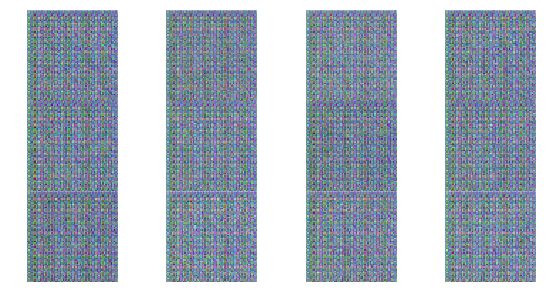

Epoch 3/50... Discriminator Loss: 0.5194... Generator Loss: 7.9860
Epoch 3/50... Discriminator Loss: 2.3936... Generator Loss: 0.2028
Epoch 4/50... Discriminator Loss: 0.5551... Generator Loss: 2.4820
Epoch 4/50... Discriminator Loss: 0.4552... Generator Loss: 3.4557
Epoch 4/50... Discriminator Loss: 0.4681... Generator Loss: 3.0622
Epoch 4/50... Discriminator Loss: 0.5191... Generator Loss: 2.7985
Epoch 5/50... Discriminator Loss: 0.5963... Generator Loss: 4.6875
Epoch 5/50... Discriminator Loss: 0.5344... Generator Loss: 2.2999
Epoch 5/50... Discriminator Loss: 0.5493... Generator Loss: 2.6808
Epoch 5/50... Discriminator Loss: 0.7018... Generator Loss: 1.6985


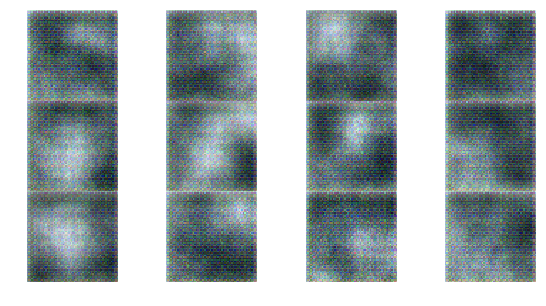

Epoch 5/50... Discriminator Loss: 0.5682... Generator Loss: 2.0158
Epoch 6/50... Discriminator Loss: 0.6210... Generator Loss: 2.8240
Epoch 6/50... Discriminator Loss: 0.6113... Generator Loss: 1.8688
Epoch 6/50... Discriminator Loss: 1.1860... Generator Loss: 4.9853
Epoch 6/50... Discriminator Loss: 0.5444... Generator Loss: 2.2741
Epoch 7/50... Discriminator Loss: 0.7569... Generator Loss: 1.3749
Epoch 7/50... Discriminator Loss: 0.5158... Generator Loss: 2.8124
Epoch 7/50... Discriminator Loss: 0.5751... Generator Loss: 2.1766
Epoch 7/50... Discriminator Loss: 0.8874... Generator Loss: 1.2026
Epoch 8/50... Discriminator Loss: 0.5616... Generator Loss: 2.5463


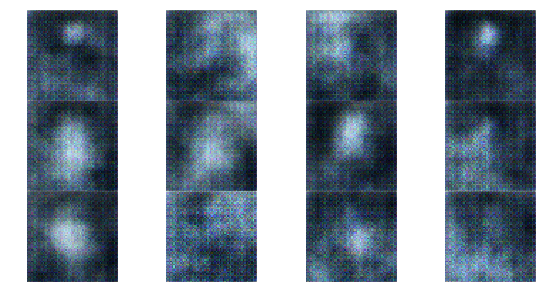

Epoch 8/50... Discriminator Loss: 0.5609... Generator Loss: 2.6454
Epoch 8/50... Discriminator Loss: 0.5067... Generator Loss: 3.0220
Epoch 8/50... Discriminator Loss: 1.2673... Generator Loss: 5.4244
Epoch 9/50... Discriminator Loss: 0.5336... Generator Loss: 2.1887
Epoch 9/50... Discriminator Loss: 0.5037... Generator Loss: 2.4371
Epoch 9/50... Discriminator Loss: 0.5046... Generator Loss: 2.5093
Epoch 9/50... Discriminator Loss: 0.5223... Generator Loss: 2.1422
Epoch 10/50... Discriminator Loss: 0.5082... Generator Loss: 2.2830
Epoch 10/50... Discriminator Loss: 0.5273... Generator Loss: 2.4607
Epoch 10/50... Discriminator Loss: 1.6984... Generator Loss: 5.2051


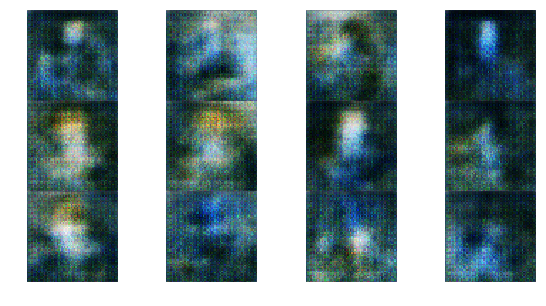

Epoch 10/50... Discriminator Loss: 0.6004... Generator Loss: 2.3514
Epoch 10/50... Discriminator Loss: 0.5047... Generator Loss: 2.1372
Epoch 11/50... Discriminator Loss: 0.5623... Generator Loss: 2.1104
Epoch 11/50... Discriminator Loss: 0.7334... Generator Loss: 1.3455
Epoch 11/50... Discriminator Loss: 0.5808... Generator Loss: 1.8539
Epoch 11/50... Discriminator Loss: 0.5191... Generator Loss: 3.1107
Epoch 12/50... Discriminator Loss: 0.4890... Generator Loss: 2.4975
Epoch 12/50... Discriminator Loss: 0.6552... Generator Loss: 1.7887
Epoch 12/50... Discriminator Loss: 0.4899... Generator Loss: 2.6000
Epoch 12/50... Discriminator Loss: 0.4595... Generator Loss: 2.7619


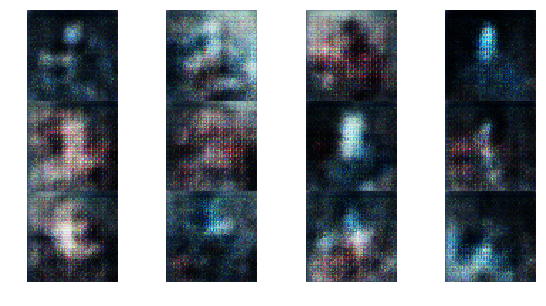

Epoch 13/50... Discriminator Loss: 0.4694... Generator Loss: 2.8702
Epoch 13/50... Discriminator Loss: 0.4814... Generator Loss: 2.3872
Epoch 13/50... Discriminator Loss: 0.7475... Generator Loss: 4.2926
Epoch 13/50... Discriminator Loss: 0.4942... Generator Loss: 3.5348
Epoch 14/50... Discriminator Loss: 0.5630... Generator Loss: 2.1762
Epoch 14/50... Discriminator Loss: 0.5094... Generator Loss: 2.6532
Epoch 14/50... Discriminator Loss: 0.4545... Generator Loss: 2.8960
Epoch 14/50... Discriminator Loss: 0.4706... Generator Loss: 2.8032
Epoch 15/50... Discriminator Loss: 0.4597... Generator Loss: 2.5784
Epoch 15/50... Discriminator Loss: 0.4980... Generator Loss: 2.6704


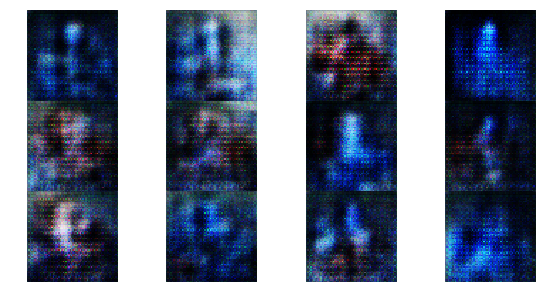

Epoch 15/50... Discriminator Loss: 0.4380... Generator Loss: 3.0465
Epoch 15/50... Discriminator Loss: 0.5547... Generator Loss: 3.5751
Epoch 15/50... Discriminator Loss: 0.4299... Generator Loss: 2.7806
Epoch 16/50... Discriminator Loss: 0.4785... Generator Loss: 2.6431
Epoch 16/50... Discriminator Loss: 0.5683... Generator Loss: 2.1197
Epoch 16/50... Discriminator Loss: 0.7793... Generator Loss: 1.4565
Epoch 16/50... Discriminator Loss: 0.4738... Generator Loss: 2.7438
Epoch 17/50... Discriminator Loss: 0.4842... Generator Loss: 3.6584
Epoch 17/50... Discriminator Loss: 0.4638... Generator Loss: 3.1995
Epoch 17/50... Discriminator Loss: 0.4337... Generator Loss: 3.1925


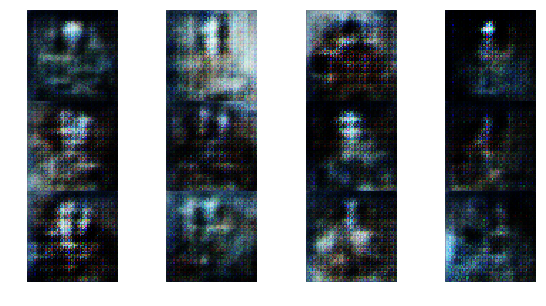

Epoch 17/50... Discriminator Loss: 0.4346... Generator Loss: 2.8581
Epoch 18/50... Discriminator Loss: 0.7787... Generator Loss: 4.2482
Epoch 18/50... Discriminator Loss: 0.5051... Generator Loss: 2.5003
Epoch 18/50... Discriminator Loss: 1.9157... Generator Loss: 7.4177
Epoch 18/50... Discriminator Loss: 0.5182... Generator Loss: 2.5391
Epoch 19/50... Discriminator Loss: 0.5589... Generator Loss: 3.0308
Epoch 19/50... Discriminator Loss: 0.5105... Generator Loss: 2.4199
Epoch 19/50... Discriminator Loss: 0.6970... Generator Loss: 3.2046
Epoch 19/50... Discriminator Loss: 0.6665... Generator Loss: 2.5631
Epoch 20/50... Discriminator Loss: 0.5365... Generator Loss: 2.1867


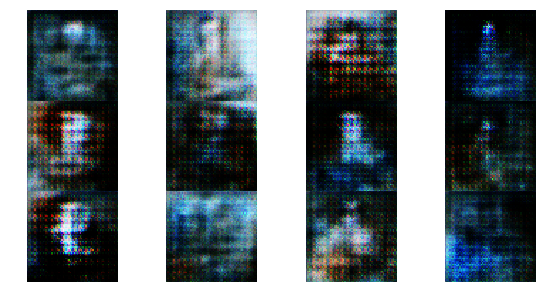

Epoch 20/50... Discriminator Loss: 0.5367... Generator Loss: 2.5611
Epoch 20/50... Discriminator Loss: 0.6325... Generator Loss: 3.9479
Epoch 20/50... Discriminator Loss: 0.6655... Generator Loss: 3.4592
Epoch 20/50... Discriminator Loss: 0.5550... Generator Loss: 3.8207
Epoch 21/50... Discriminator Loss: 0.5045... Generator Loss: 2.5562
Epoch 21/50... Discriminator Loss: 1.3962... Generator Loss: 1.0238
Epoch 21/50... Discriminator Loss: 1.0111... Generator Loss: 0.9446
Epoch 21/50... Discriminator Loss: 0.4841... Generator Loss: 2.7138
Epoch 22/50... Discriminator Loss: 0.4597... Generator Loss: 2.9954
Epoch 22/50... Discriminator Loss: 0.5269... Generator Loss: 2.9476


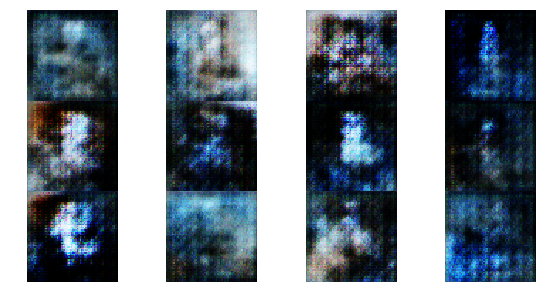

Epoch 22/50... Discriminator Loss: 0.4907... Generator Loss: 2.6910
Epoch 22/50... Discriminator Loss: 0.5183... Generator Loss: 2.5203
Epoch 23/50... Discriminator Loss: 0.7296... Generator Loss: 1.7018
Epoch 23/50... Discriminator Loss: 0.7067... Generator Loss: 1.9004
Epoch 23/50... Discriminator Loss: 0.5125... Generator Loss: 2.7745
Epoch 23/50... Discriminator Loss: 0.5023... Generator Loss: 3.4971
Epoch 24/50... Discriminator Loss: 0.7099... Generator Loss: 1.4008
Epoch 24/50... Discriminator Loss: 0.4534... Generator Loss: 3.2676
Epoch 24/50... Discriminator Loss: 0.5310... Generator Loss: 2.2011
Epoch 24/50... Discriminator Loss: 0.6997... Generator Loss: 1.6154


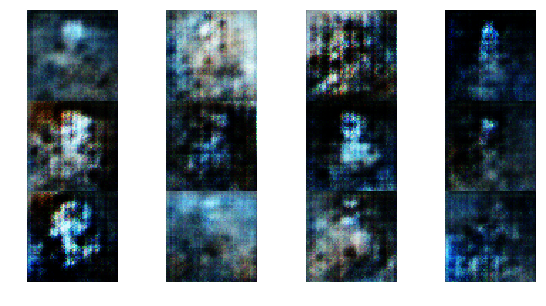

Epoch 25/50... Discriminator Loss: 0.4968... Generator Loss: 2.9079
Epoch 25/50... Discriminator Loss: 0.5694... Generator Loss: 2.2867
Epoch 25/50... Discriminator Loss: 0.5041... Generator Loss: 2.7771
Epoch 25/50... Discriminator Loss: 0.8367... Generator Loss: 3.6187
Epoch 25/50... Discriminator Loss: 0.4403... Generator Loss: 3.5110
Epoch 26/50... Discriminator Loss: 0.5649... Generator Loss: 2.9707
Epoch 26/50... Discriminator Loss: 0.5010... Generator Loss: 2.5377
Epoch 26/50... Discriminator Loss: 0.7113... Generator Loss: 1.4384
Epoch 26/50... Discriminator Loss: 0.5489... Generator Loss: 1.9973
Epoch 27/50... Discriminator Loss: 0.4765... Generator Loss: 2.4802


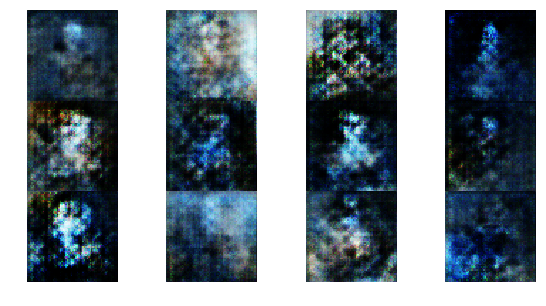

Epoch 27/50... Discriminator Loss: 0.4914... Generator Loss: 3.3180
Epoch 27/50... Discriminator Loss: 0.4574... Generator Loss: 3.2819
Epoch 27/50... Discriminator Loss: 0.5155... Generator Loss: 3.6855
Epoch 28/50... Discriminator Loss: 0.5144... Generator Loss: 3.1847
Epoch 28/50... Discriminator Loss: 0.5750... Generator Loss: 1.9553
Epoch 28/50... Discriminator Loss: 0.4961... Generator Loss: 3.2489
Epoch 28/50... Discriminator Loss: 0.4701... Generator Loss: 2.5999
Epoch 29/50... Discriminator Loss: 0.7095... Generator Loss: 1.4966
Epoch 29/50... Discriminator Loss: 0.4519... Generator Loss: 3.1195
Epoch 29/50... Discriminator Loss: 0.5401... Generator Loss: 2.1859


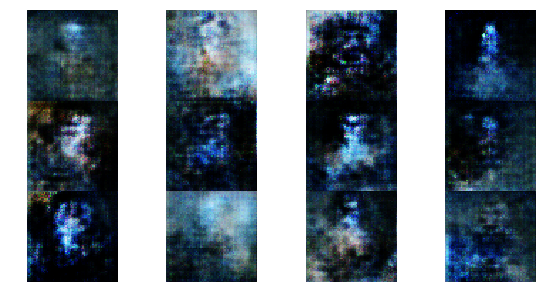

Epoch 29/50... Discriminator Loss: 0.7956... Generator Loss: 2.2157
Epoch 30/50... Discriminator Loss: 0.4645... Generator Loss: 2.7786
Epoch 30/50... Discriminator Loss: 0.4856... Generator Loss: 2.5439
Epoch 30/50... Discriminator Loss: 0.5085... Generator Loss: 2.8633
Epoch 30/50... Discriminator Loss: 0.5652... Generator Loss: 3.1616
Epoch 30/50... Discriminator Loss: 0.4901... Generator Loss: 3.5320
Epoch 31/50... Discriminator Loss: 0.5137... Generator Loss: 2.9077
Epoch 31/50... Discriminator Loss: 0.4537... Generator Loss: 2.8889
Epoch 31/50... Discriminator Loss: 0.8561... Generator Loss: 1.7054
Epoch 31/50... Discriminator Loss: 0.4705... Generator Loss: 2.7148


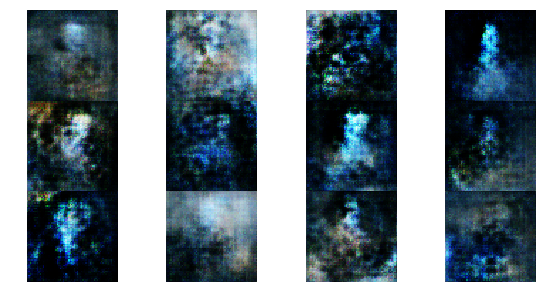

Epoch 32/50... Discriminator Loss: 0.5031... Generator Loss: 2.6266
Epoch 32/50... Discriminator Loss: 0.4996... Generator Loss: 3.2747
Epoch 32/50... Discriminator Loss: 0.4462... Generator Loss: 3.3551
Epoch 32/50... Discriminator Loss: 0.4641... Generator Loss: 3.0784
Epoch 33/50... Discriminator Loss: 0.5082... Generator Loss: 3.4565
Epoch 33/50... Discriminator Loss: 0.5004... Generator Loss: 2.2943
Epoch 33/50... Discriminator Loss: 0.4791... Generator Loss: 2.8404
Epoch 33/50... Discriminator Loss: 0.4767... Generator Loss: 2.6650
Epoch 34/50... Discriminator Loss: 0.5293... Generator Loss: 3.4676
Epoch 34/50... Discriminator Loss: 0.4251... Generator Loss: 3.5774


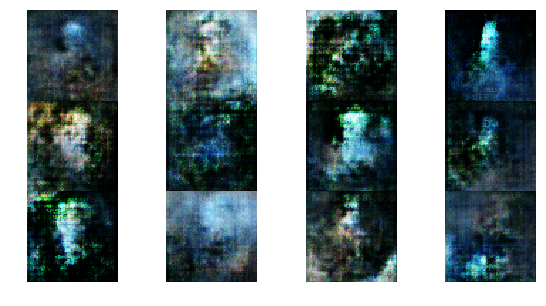

Epoch 34/50... Discriminator Loss: 0.4743... Generator Loss: 2.7453
Epoch 34/50... Discriminator Loss: 0.4728... Generator Loss: 3.4417
Epoch 35/50... Discriminator Loss: 0.4165... Generator Loss: 3.4527
Epoch 35/50... Discriminator Loss: 0.4386... Generator Loss: 2.9435
Epoch 35/50... Discriminator Loss: 0.4360... Generator Loss: 3.3314
Epoch 35/50... Discriminator Loss: 0.5121... Generator Loss: 3.2506
Epoch 35/50... Discriminator Loss: 0.4090... Generator Loss: 3.4410
Epoch 36/50... Discriminator Loss: 0.4687... Generator Loss: 2.9201
Epoch 36/50... Discriminator Loss: 0.7760... Generator Loss: 1.8060
Epoch 36/50... Discriminator Loss: 1.3375... Generator Loss: 0.8894


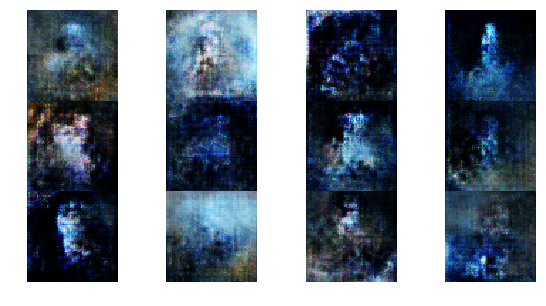

Epoch 36/50... Discriminator Loss: 2.7457... Generator Loss: 8.1892
Epoch 37/50... Discriminator Loss: 0.5699... Generator Loss: 3.0875
Epoch 37/50... Discriminator Loss: 0.5320... Generator Loss: 2.7018
Epoch 37/50... Discriminator Loss: 0.4688... Generator Loss: 2.9620
Epoch 37/50... Discriminator Loss: 0.4562... Generator Loss: 3.2784
Epoch 38/50... Discriminator Loss: 0.4515... Generator Loss: 3.0695
Epoch 38/50... Discriminator Loss: 0.4488... Generator Loss: 3.2308
Epoch 38/50... Discriminator Loss: 0.4827... Generator Loss: 2.4602
Epoch 38/50... Discriminator Loss: 0.4288... Generator Loss: 3.3971
Epoch 39/50... Discriminator Loss: 0.5381... Generator Loss: 2.2003


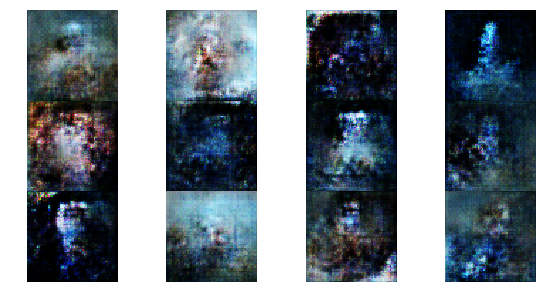

Epoch 39/50... Discriminator Loss: 0.4107... Generator Loss: 3.3321
Epoch 39/50... Discriminator Loss: 0.4413... Generator Loss: 3.0736
Epoch 39/50... Discriminator Loss: 0.4141... Generator Loss: 3.2291
Epoch 40/50... Discriminator Loss: 0.4324... Generator Loss: 4.0204
Epoch 40/50... Discriminator Loss: 0.4195... Generator Loss: 2.9696
Epoch 40/50... Discriminator Loss: 0.4147... Generator Loss: 3.4685
Epoch 40/50... Discriminator Loss: 0.4813... Generator Loss: 2.4900
Epoch 40/50... Discriminator Loss: 0.4103... Generator Loss: 4.1879
Epoch 41/50... Discriminator Loss: 0.3968... Generator Loss: 3.7712
Epoch 41/50... Discriminator Loss: 0.4589... Generator Loss: 2.5828


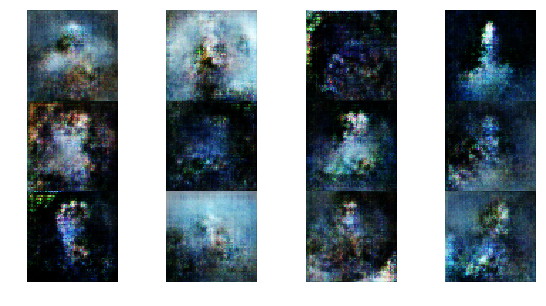

Epoch 41/50... Discriminator Loss: 0.3952... Generator Loss: 3.5223
Epoch 41/50... Discriminator Loss: 0.4835... Generator Loss: 2.5409
Epoch 42/50... Discriminator Loss: 0.4098... Generator Loss: 3.6649
Epoch 42/50... Discriminator Loss: 0.4395... Generator Loss: 3.3729
Epoch 42/50... Discriminator Loss: 0.4110... Generator Loss: 3.2711
Epoch 42/50... Discriminator Loss: 0.3923... Generator Loss: 3.6389
Epoch 43/50... Discriminator Loss: 0.4084... Generator Loss: 3.4354
Epoch 43/50... Discriminator Loss: 0.3993... Generator Loss: 3.3334
Epoch 43/50... Discriminator Loss: 0.4918... Generator Loss: 2.6146
Epoch 43/50... Discriminator Loss: 0.4343... Generator Loss: 2.9060


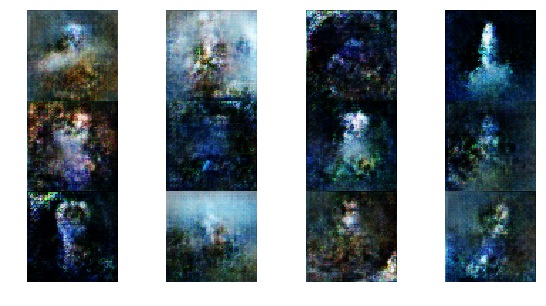

Epoch 44/50... Discriminator Loss: 0.5277... Generator Loss: 2.2834
Epoch 44/50... Discriminator Loss: 0.3981... Generator Loss: 3.5555
Epoch 44/50... Discriminator Loss: 0.8376... Generator Loss: 3.1145
Epoch 44/50... Discriminator Loss: 1.6091... Generator Loss: 0.5744
Epoch 45/50... Discriminator Loss: 0.6335... Generator Loss: 2.0679
Epoch 45/50... Discriminator Loss: 0.4657... Generator Loss: 2.8842
Epoch 45/50... Discriminator Loss: 0.4557... Generator Loss: 3.0215
Epoch 45/50... Discriminator Loss: 0.5319... Generator Loss: 2.2603
Epoch 45/50... Discriminator Loss: 0.4046... Generator Loss: 3.5045
Epoch 46/50... Discriminator Loss: 0.3967... Generator Loss: 3.5882


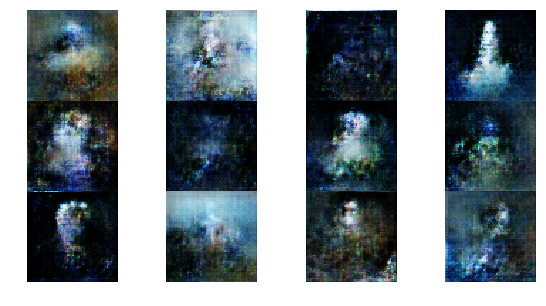

Epoch 46/50... Discriminator Loss: 0.4404... Generator Loss: 2.7534
Epoch 46/50... Discriminator Loss: 0.4102... Generator Loss: 3.5596
Epoch 46/50... Discriminator Loss: 0.4875... Generator Loss: 2.5979
Epoch 47/50... Discriminator Loss: 0.3900... Generator Loss: 3.8199
Epoch 47/50... Discriminator Loss: 0.4068... Generator Loss: 3.3795
Epoch 47/50... Discriminator Loss: 0.4068... Generator Loss: 3.1936
Epoch 47/50... Discriminator Loss: 0.3933... Generator Loss: 3.7726
Epoch 48/50... Discriminator Loss: 0.4035... Generator Loss: 3.4212
Epoch 48/50... Discriminator Loss: 0.4074... Generator Loss: 3.5590
Epoch 48/50... Discriminator Loss: 0.4415... Generator Loss: 2.6948


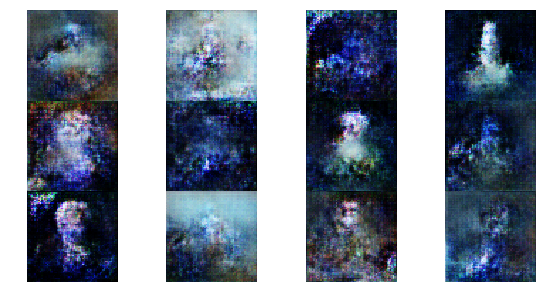

Epoch 48/50... Discriminator Loss: 0.3941... Generator Loss: 3.5719
Epoch 49/50... Discriminator Loss: 0.4465... Generator Loss: 2.8567
Epoch 49/50... Discriminator Loss: 0.3999... Generator Loss: 3.5759
Epoch 49/50... Discriminator Loss: 0.4371... Generator Loss: 3.5107
Epoch 49/50... Discriminator Loss: 0.3839... Generator Loss: 3.5641
Epoch 50/50... Discriminator Loss: 0.3923... Generator Loss: 4.5793
Epoch 50/50... Discriminator Loss: 0.3857... Generator Loss: 3.4460
Epoch 50/50... Discriminator Loss: 0.3852... Generator Loss: 3.5622
Epoch 50/50... Discriminator Loss: 0.4160... Generator Loss: 3.1479
Epoch 50/50... Discriminator Loss: 0.3828... Generator Loss: 3.5368


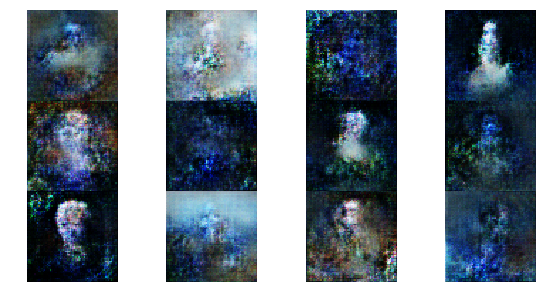

In [22]:
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

We can see that the color scheme of the generated images are pretty similar to the images of the paintings (images are generally dark, with hints of blue, and light brown).

### Evaluating the DCGAN

#### Qualitative Evaluation
Initially, the generated images started off as random noise. But over time, we observe that the generated images are getting closer and closer to looking like an authentic artwork. While I am not sufficiently close to becoming the next great artist, the generated images were good enough to 'fool' art dealers and curators (the discriminator, in this case). 

#### Quantitative Evaluation
We can also evaluate the performance of the discriminator and generator by taking a closer look at their respective losses over the timesteps. We note that initially, the generator struggled to produce images that could fool the discriminator. However, after approximately 25 timesteps, it was able to 'understand the process' of generating images. 

Generally, we should expect losses from both networks to stabilise after some time; this simply implies that the discriminator and the generator are equally adept at their respective tasks.

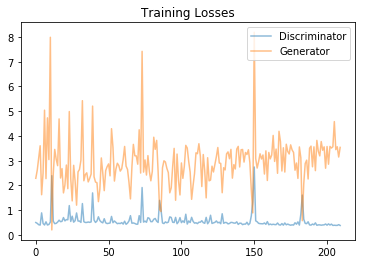

In [23]:
def plot_losses(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

plot_losses(losses)

Initially, the losses appear to vary wildly - the discriminator and generator seems to be learning how to discriminate and generate images. After about 20 to 25 timesteps, however, both networks seem to be doing very well. In particular, we note that the discriminator loss hovers around 1, while the generator loss oscillates between 1 and 3. This tells us that both models are at a standstill.